In [74]:
import copy
import re
from dataclasses import dataclass
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd

from alns import ALNS, State
from alns.criteria import *
from alns.weight_schemes import *

In [34]:
%matplotlib inline

In [3]:
SEED = 5432

# The resource-constrained project scheduling problem

The following explanation is largely based on [this paper](https://pms2020.sciencesconf.org/300164/document).

The goal of the RCPSP is to schedule a set of project activities $V = \{ 0, 1, 2, \ldots, n \}$, such that the makespan of the project is minimised.
Each activity $i \in V$ has a duration $d_i \in \mathbb{N}$.
Precedence constraints impose that an activity $i \in V$ can only start after all its predecessor activities have been completed.
The precedence constraints are given by a set of edges $E \subset V \times V$, where $(i, j) \in E$ means that $i$ must be completed before $j$ can commence.
Resource constraints, on the other hand, impose that an activity can only be scheduled if sufficient resources are available.
There are $K = \{ 1, 2, \ldots, m \}$ renewable resources available, with $R_k$ indicating the availability of resource $k$.
Each activity $i \in V$ requires $r_{ik}$ units of resource $k$.
A solution to the RCPSP is a schedule of activities $S = \{ S_0, S_1, \ldots, S_n \}$, where $S_i$ is the starting time of activity $i$.
The project starts at time $S_0 = 0$, and completes at $S_n$, where activities $0$ and $n$ are dummy activities that represent the start and completion of the project, respectively.

In this notebook, we solve an instance of the RCPSP using ALNS.
In particular, we solve instance `j9041_6` of the [PSPLib](http://www.om-db.wi.tum.de/psplib/library.html) benchmark suite.
This instance consists of 90 jobs, and four resources.


## Data instance

In [115]:
@dataclass
class ProblemData:
    num_jobs: int
    num_resources: int

    durations: np.ndarray  # job durations
    successors: List[List[int]]  # job successors
    needs: np.ndarray  # job resource needs
    resources: np.ndarray  # resource capacities

    @property
    def last_job(self) -> int:
        return self.num_jobs - 1

    @classmethod
    def read_instance(cls, path: str) -> "ProblemData":
        """
        Reads an instance of the RCPSP from a file.
        Assumes the data is in the PSPLib format.

        Loosely based on:
        https://github.com/baobabsoluciones/hackathonbaobab2020.
        """
        with open(path) as fh:
            lines = fh.readlines()

        prec_idx = lines.index("PRECEDENCE RELATIONS:\n")
        req_idx = lines.index("REQUESTS/DURATIONS:\n")
        avail_idx = lines.index("RESOURCEAVAILABILITIES:\n")

        successors = []

        for line in lines[prec_idx + 2: req_idx - 1]:
            _, _, modes, num_succ, *jobs, _ = re.split("\s+", line)
            successors.append(list(map(lambda x: int(x) - 1, jobs)))

        needs = []
        durations = []

        for line in lines[req_idx + 3: avail_idx - 1]:
            _, _, _, duration, *consumption, _ = re.split("\s+", line)

            needs.append(list(map(int, consumption)))
            durations.append(int(duration))

        _, *avail, _ = re.split("\s+", lines[avail_idx + 2])
        resources = list(map(int, avail))

        return ProblemData(len(durations),
                           len(resources),
                           np.array(durations),
                           successors,
                           np.array(needs),
                           np.array(resources))

In [114]:
instance = ProblemData.read_instance('j9041_6.sm')

UNSCHEDULED = -1  # sentinel value
destroy_pct = 0.15

## Solution state

In [103]:
@dataclass
class RcpspState(State):
    """
    Solution state for the resource-constrained project scheduling problem.
    """
    schedule: np.ndarray

    @property
    def unscheduled(self) -> np.ndarray:
        return np.argwhere(self.schedule == UNSCHEDULED).flatten()

    @property
    def scheduled(self) -> np.ndarray:
        return np.argwhere(self.schedule != UNSCHEDULED).flatten()

    def objective(self) -> int:
        return self.schedule[instance.last_job]

    def unschedule_job(self, job: int):
        self.schedule[job] = UNSCHEDULED

    def schedule_job(self, job: int, start: int):
        self.schedule[job] = start

    def resources_used(self):
        if len(self.scheduled) == 0:
            return np.zeros((1, instance.num_resources))

        starts = self.schedule[self.scheduled]
        ends = starts + instance.durations[self.scheduled]
        used = np.zeros((np.max(ends), instance.num_resources))

        for job, start, end in zip(self.scheduled, starts, ends):
            for resource, need in enumerate(instance.needs[job]):
                used[start:end, resource] += need

        return used

    def plot(self):
        fig = plt.figure(figsize=(12, 6 + instance.num_resources))

        hr = [1] * (instance.num_resources + 1)
        hr[0] = 6

        gs = plt.GridSpec(nrows=1 + instance.num_resources,
                          ncols=1,
                          height_ratios=hr)

        gantt = fig.add_subplot(gs[0, 0])
        gantt.barh(np.arange(instance.num_jobs),
                   instance.durations,
                   left=self.schedule)

        gantt.set_xlim(0, self.objective())
        gantt.set_ylim(0, instance.last_job)
        gantt.invert_yaxis()

        gantt.set_title("Gantt chart")

        used = self.resources_used()

        for res in range(instance.num_resources):
            res_ax = fig.add_subplot(gs[res + 1, 0], sharex=gantt)
            res_ax.bar(np.arange(used.shape[0]), used[:, res])

            res_ax.set_ylim(0, instance.resources[res])
            res_ax.set_ylabel(f"R{res + 1}")

            if res == instance.num_resources - 1:
                res_ax.set_xlabel("Time")

        plt.tight_layout()

## Destroy operators

In [127]:
def random_removal(state: RcpspState, rnd_state: rnd.RandomState):
    """
    Removes a random set of jobs from the schedule.
    """
    state = copy.deepcopy(state)
    removed = 0

    while removed < int(instance.num_jobs * destroy_pct):
        job = rnd_state.choice(state.scheduled[1:-1])
        state.unschedule_job(job)
        removed += 1

        pool = instance.successors[job]

        while pool:
            succ = pool.pop()
            state.unschedule_job(succ)
            removed += 1

            pool += instance.successors[succ]

    return state

## Repair operators

In [128]:
def greedy_repair(state: RcpspState, rnd_state: rnd.RandomState):
    unscheduled = state.unscheduled.tolist()
    rnd_state.shuffle(unscheduled)

    used = state.resources_used()
    used.resize((instance.durations.sum(), instance.num_resources))

    while unscheduled:
        job = unscheduled.pop(0)

        if job == instance.last_job:
            continue

        duration = instance.durations[job]
        needs = instance.needs[job]

        for start in range(0, used.shape[0] + 1):
            res_ok = np.all(used[start:start + duration, :] + needs <= instance.resources)
            suc_ok = all(state.schedule[suc] >= start + duration
                         for suc in instance.successors[job]
                         if state.schedule[suc] != UNSCHEDULED)

            if res_ok and suc_ok:
                state.schedule_job(job, start)
                used[start:start + duration, :] += needs
                break

    used = state.resources_used()
    state.schedule_job(instance.last_job, used.shape[0])

    return state

## Initial solution

In [129]:
rnd_state = rnd.RandomState(SEED)

In [135]:
unscheduled = [UNSCHEDULED for job in range(instance.num_jobs)]
unscheduled[0] = 0

init_sol = greedy_repair(RcpspState(np.array(unscheduled)), rnd_state)

print(f"Initial objective: {init_sol.objective()}")

Initial objective: 141


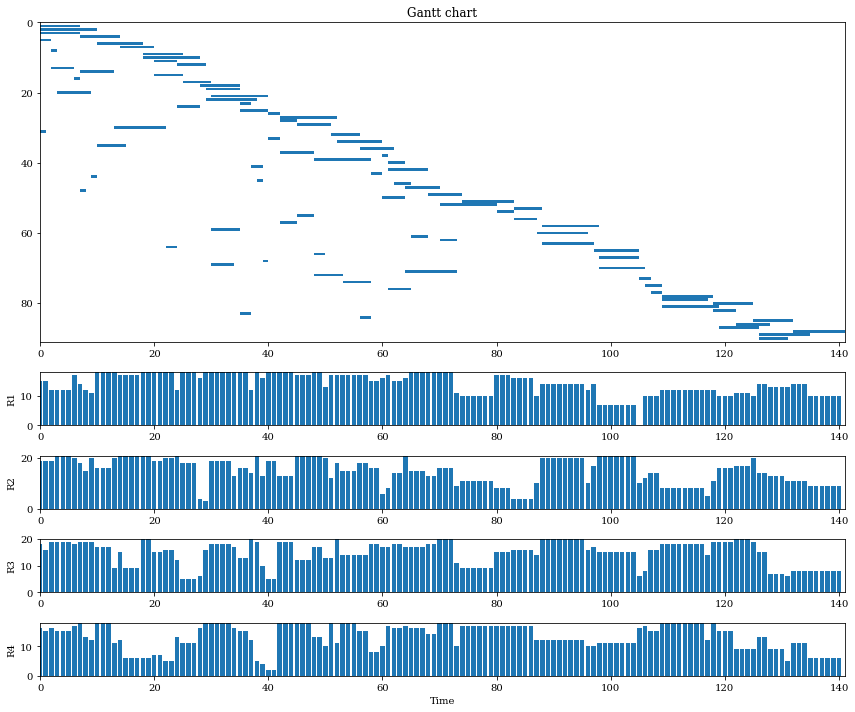

In [136]:
init_sol.plot()

## Heuristic solution

In [137]:
alns = ALNS(rnd_state)

alns.add_destroy_operator(random_removal)

alns.add_repair_operator(greedy_repair)

In [138]:
crit = HillClimbing() #SimulatedAnnealing.autofit(init_sol.objective(), 0.1, 0.9, 5_000)
weights = SegmentedWeights([3, 2, 1, 0.5], 1, 1, 0.8)

res = alns.iterate(init_sol, weights, crit, iterations=5_000)

sol = res.best_state
obj = sol.objective()

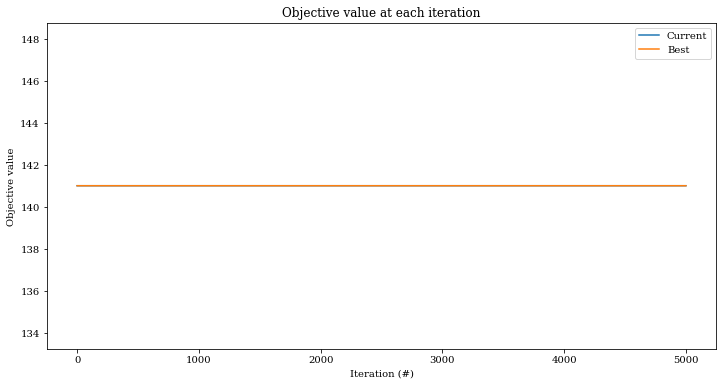

In [139]:
_, ax = plt.subplots(figsize=(12, 6))
res.plot_objectives(ax=ax)